In [2]:
%cd /data3/yokoyama/labvideo
import os
import sys
import shutil
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import yaml

sys.path.append(".")
from src.utils import json_handler, video, yaml_handler

/data3/yokoyama/anaconda3/envs/labvideo/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/data3/yokoyama/labvideo


In [3]:
config = yaml_handler.load("datasets/yolov8_finetuning/yolov8_finetuning.yaml")
classes = config.names.__dict__
classes

{'0': 'centrifuge tube',
 '1': 'centrifuge tube cap',
 '2': 'culture dish',
 '3': 'pipette',
 '4': 'dispenser',
 '5': 'hand'}

In [4]:
video_name = "Failures11"
ann_data = np.loadtxt(f"out/{video_name}/{video_name}_ann.tsv", skiprows=1, dtype=str)
yolo_preds = np.loadtxt(
    f"out/{video_name}/{video_name}_det_finetuned.tsv", skiprows=1, dtype=float
)

cap = video.Capture(f"video/{video_name}.mp4")
frame_count = cap.frame_count
frame_size = cap.size
del cap

# 物体の出現タイミング・頻度

In [ ]:
last_n_frame = int(np.max(yolo_preds[:, 0]))
counts_dict = {
    int(label): [0 for n_frame in range(last_n_frame + 1)]
    for label in classes.keys()
}

for pred in yolo_preds:
    n_frame = int(pred[0])
    label = int(pred[6])

    counts_dict[label][n_frame] += 1

max_n_counts = 0
for counts in counts_dict.values():
    if np.max(counts) > max_n_counts:
        max_n_counts = np.max(counts)
print("max_n_counts", max_n_counts)

max_n_counts 7


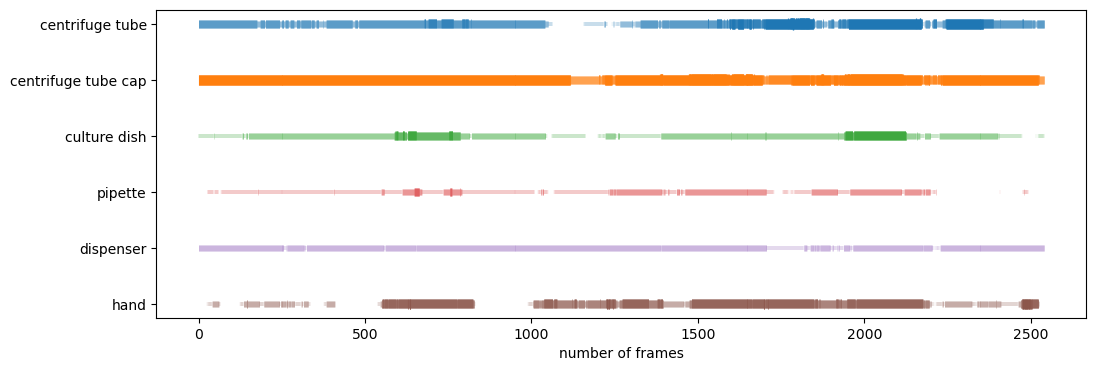

In [43]:
plt.figure(figsize=(12, 4))
for label, counts in counts_dict.items():
    y = np.full((len(counts),), len(classes) - (label + 1))
    x = np.arange(len(counts))
    counts = np.array(counts).astype(float)
    s = counts * 10
    alpha = (counts + 1) / (max_n_counts + 1)
    plt.scatter(x, y, label=classes[str(label)], marker="|", s=s, alpha=alpha, linewidths=alpha)
plt.xlabel("number of frames")
ticks = [len(classes) - (int(k) + 1) for k in classes.keys()]
plt.yticks(ticks, list(classes.values()))
plt.show()

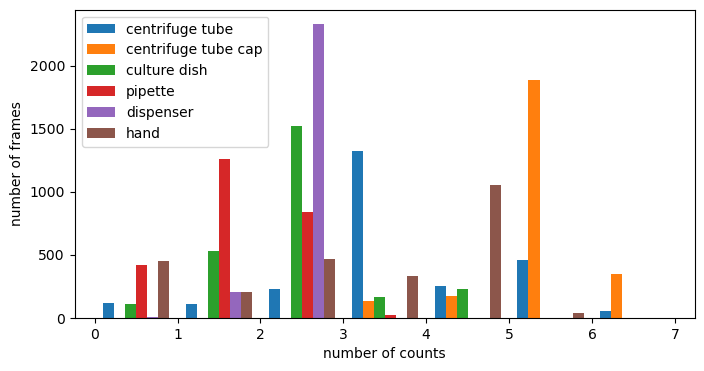

In [44]:
plt.figure(figsize=(8, 4))
counts_hist = np.array(list(counts_dict.values())).T
labels = list(classes.values())
plt.hist(counts_hist, max_n_counts, histtype='bar', label=labels)
plt.legend()
plt.xlabel("number of counts")
plt.ylabel("number of frames")
plt.show()


# 異常発生場所のアノテーションと物体認識結果の分析
- 異常発生時とそうでない時の物体の配置の分布の違い
- 異常発生までの各物体の移動経路

In [ ]:
ann_unique_labels = np.unique(ann_data[:, 8])
ann_timings = {ann_label: 0 for ann_label in ann_unique_labels}
for ann_label in ann_unique_labels:
    ann_tmp = ann_data[ann_data[:, 8] == ann_label]
    n_frame = int(ann_tmp[0, 0])
    ann_timings[ann_label] = n_frame

ann_timings

{'1(C42)': 358, '2(B41)': 597, '3(A12)': 1304, '4(A22)': 1528, '5(A36)': 2190}

In [ ]:
ann_frames = {ann_label: None for ann_label in ann_unique_labels}

cap = video.Capture(f"video/{video_name}.mp4")
for ann_label, n_frame in ann_timings.items():
    cap.set_pos_frame_count(n_frame)
    ret, frame = cap.read()
    if ret == False:
        raise ValueError
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ann_frames[ann_label] = frame

del cap